Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training Pipeline - Custom Script
_**Training many models using a custom script**_

----

This notebook demonstrates how to create a pipeline that trains and registers many models using a custom script. We utilize the [ParallelRunStep](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-parallel-run-step) to parallelize the process of training the models to make the process more efficient. For this solution accelerator we are using the [OJ Sales Dataset](https://azure.microsoft.com/en-us/services/open-datasets/catalog/sample-oj-sales-simulated/) to train individual models that predict sales for each store and brand of orange juice.

The model we use here is a simple, regression-based forecaster built on scikit-learn and pandas utilities. See the [training script](scripts/train.py) to see how the forecaster is constructed. This forecaster is intended for demonstration purposes, so it does not handle the large variety of special cases that one encounters in time-series modeling. For instance, the model here assumes that all time-series are comprised of regularly sampled observations on a contiguous interval with no missing values. The model does not include any handling of categorical variables. For a more general-use forecaster that handles missing data, advanced featurization, and automatic model selection, see the [AutoML Forecasting task](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-forecast). Also, see the notebooks demonstrating [AutoML forecasting in a many models scenario](../Automated_ML).

### Prerequisites
At this point, you should have already:

1. Created your AML Workspace using the [00_Setup_AML_Workspace notebook](../00_Setup_AML_Workspace.ipynb)
2. Run [01_Data_Preparation.ipynb](../01_Data_Preparation.ipynb) to setup your compute and create the dataset

#### Please ensure you have the latest version of the Azure ML SDK and also install Pipeline Steps Package and other required python packages.

In [1]:
#!pip install --upgrade azureml-sdk

In [2]:
#!pip install azureml-pipeline-steps

In [3]:
# !pip install seaborn
# !pip install pandas
# !pip install matplotlib

## 1.0 Connect to workspace and datastore

In [4]:
from azureml.core import Workspace

# set up workspace
ws = Workspace.from_config()

# set up datastores
dstore = ws.get_default_datastore()

print('Workspace Name: ' + ws.name, 
      'Azure Region: ' + ws.location, 
      'Subscription Id: ' + ws.subscription_id, 
      'Resource Group: ' + ws.resource_group, 
      sep = '\n')

Workspace Name: wsp-many-models
Azure Region: eastus2
Subscription Id: f6c1e253-ecd5-4de6-841f-e10afd3947e3
Resource Group: rg-many-models


## 2.0 Create an experiment

In [5]:
from azureml.core import Experiment

experiment = Experiment(ws, 'oj_training_pipeline')

print('Experiment name: ' + experiment.name)

Experiment name: oj_training_pipeline


## 3.0 Get the training Dataset

Next, we get the training Dataset using the [Dataset.get_by_name()](https://docs.microsoft.com/python/api/azureml-core/azureml.core.dataset.dataset#get-by-name-workspace--name--version--latest--) method.

This is the training dataset we created and registered in the [data preparation notebook](../01_Data_Preparation.ipynb). If you chose to use only a subset of the files, the training dataset name will be `oj_data_small_train`. Otherwise, the name you'll have to use is `oj_data_train`. 

We recommend to start with the small dataset and make sure everything runs successfully, then scale up to the full dataset.

In [6]:
dataset_name = 'oj_data_small_train'

In [7]:
from azureml.core.dataset import Dataset

dataset = Dataset.get_by_name(ws, name=dataset_name)
dataset_input = dataset.as_named_input(dataset_name)

## 4.0 Create the training pipeline
Now that the workspace, experiment, and dataset are set up, we can put together a pipeline for training.

### 4.1 Configure environment for ParallelRunStep
An [environment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-environments) defines a collection of resources that we will need to run our pipelines. We configure a reproducible Python environment for our training script including the [scikit-learn](https://scikit-learn.org/stable/index.html) python library.

In [8]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

train_env = Environment(name="many_models_environment")
train_conda_deps = CondaDependencies.create(pip_packages=['sklearn', 'pandas', 'joblib', 'azureml-defaults', 'azureml-core', 'azureml-train'])
train_env.python.conda_dependencies = train_conda_deps

### 4.2 Choose a compute target 

Currently ParallelRunConfig only supports AMLCompute. This is the compute cluster you created in the [setup notebook](../00_Setup_AML_Workspace.ipynb#3.0-Create-compute-cluster).

In [9]:
cpu_cluster_name = "cpucluster5"

In [10]:
from azureml.core.compute import AmlCompute

compute = AmlCompute(ws, cpu_cluster_name)

### 4.3 Set up ParallelRunConfig

[ParallelRunConfig](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-steps/azureml.pipeline.steps.parallel_run_config.parallelrunconfig?view=azure-ml-py) provides the configuration for the ParallelRunStep we'll be creating next. Here we specify the environment and compute target we created above along with the entry script that will be for each batch.

There's a number of important parameters to configure including:
- **mini_batch_size**: The number of files per batch. If you have 500 files and mini_batch_size is 10, 50 batches would be created containing 10 files each. Batches are split across the various nodes. 

- **node_count**: The number of compute nodes to be used for running the user script. For the small sample of OJ datasets, we only need a single node, but you will likely need to increase this number for larger datasets composed of more files. If you increase the node count beyond five here, you may need to increase the max_nodes for the compute cluster as well.

- **process_count_per_node**: The number of processes per node. 

- **run_invocation_timeout**: The run() method invocation timeout in seconds. The timeout should be set to be higher than the maximum training time of one model (in seconds), by default it's 60. Since the batches that takes the longest to train are about 120 seconds, we set it to be 180 to ensure the method has adequate time to run.


We also added tags to preserve the information about our training cluster's node count, process count per node, and dataset name. You can find the 'Tags' column in Azure Machine Learning Studio.

In [11]:
from azureml.pipeline.steps import ParallelRunConfig

processes_per_node = 2
node_count = 2
timeout = 900 #15min

parallel_run_config = ParallelRunConfig(
    source_directory='./scripts',
    entry_script='train.py',
    mini_batch_size="1",
    run_invocation_timeout=timeout,
    error_threshold=-1,
    output_action="append_row",
    environment=train_env,
    process_count_per_node=processes_per_node,
    compute_target=compute,
    node_count=node_count,
    run_max_try=3)

### 4.4 Set up ParallelRunStep

This [ParallelRunStep](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-steps/azureml.pipeline.steps.parallel_run_step.parallelrunstep?view=azure-ml-py) is the main step in our training pipeline. 

First, we set up the output directory and define the pipeline's output name. The datastore that stores the pipeline's output data is Workspace's default datastore.

In [12]:
from azureml.pipeline.core import PipelineData

output_dir = PipelineData(name="training_output", datastore=dstore)

We provide our ParallelRunStep with a name, the ParallelRunConfig created above and several other parameters:

- **inputs**: A list of input datasets. Here we'll use the dataset created in the previous notebook. The number of files in that path determines the number of models will be trained in the ParallelRunStep.

- **output**: A PipelineData object that corresponds to the output directory. We'll use the output directory we just defined. 

- **arguments**: A list of arguments required for the train.py entry script. Here, we provide the schema for the timeseries data - i.e. the names of target, timestamp, and id columns - as well as columns that should be dropped prior to modeling, a string identifying the model type, and the number of observations we want to leave aside for testing.

In [13]:
from azureml.pipeline.steps import ParallelRunStep

parallel_run_step = ParallelRunStep(
    name="many-models-training",
    parallel_run_config=parallel_run_config,
    inputs=[dataset_input],
    output=output_dir,
    allow_reuse=False,
    arguments=['--target_column', 'Quantity', 
               '--timestamp_column', 'WeekStarting', 
               '--timeseries_id_columns', 'Store', 'Brand',
               '--drop_columns', 'Revenue', 'Store', 'Brand',
               '--model_type', 'gb',
               '--test_size', 20]
)

## 5.0 Run the pipeline
Next, we submit our pipeline to run. The run will train models for each dataset using a train set, compute accuracy metrics for the fits using a test set, and finally re-train models with all the data available. With 10 files, this should only take a few minutes but with the full dataset this can take over an hour.

In [14]:
from azureml.pipeline.core import Pipeline

pipeline = Pipeline(workspace=ws, steps=[parallel_run_step])
run = experiment.submit(pipeline)

Created step many-models-training [7223eb06][a9f3f072-fb8a-4ea3-8c27-46498f100782], (This step will run and generate new outputs)
Submitted PipelineRun eee35272-47a2-401d-a198-f7e940107e73
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/eee35272-47a2-401d-a198-f7e940107e73?wsid=/subscriptions/f6c1e253-ecd5-4de6-841f-e10afd3947e3/resourcegroups/rg-many-models/workspaces/wsp-many-models&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


In [15]:
#Wait for the run to complete
run.wait_for_completion(show_output=False, raise_on_error=True)

PipelineRunId: eee35272-47a2-401d-a198-f7e940107e73
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/eee35272-47a2-401d-a198-f7e940107e73?wsid=/subscriptions/f6c1e253-ecd5-4de6-841f-e10afd3947e3/resourcegroups/rg-many-models/workspaces/wsp-many-models&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


'Finished'

## 6.0 View results of training pipeline
The dataframe we return in the run method of train.py is outputted to *parallel_run_step.txt*. To see the results of our training pipeline, we'll download that file, read in the data to a DataFrame, and then visualize the results, including the in-sample metrics.
The run submitted to the Azure Machine Learning Training Compute Cluster may take a while. The output is not generated until the run is complete. You can monitor the status of the run in Azure Portal https://ml.azure.com

### 6.1 Download parallel_run_step.txt locally

In [16]:
import os

def download_results(run, target_dir=None, step_name='many-models-training', output_name='training_output'):
    stitch_run = run.find_step_run(step_name)[0]
    port_data = stitch_run.get_output_data(output_name)
    port_data.download(target_dir, show_progress=True)
    return os.path.join(target_dir, 'azureml', stitch_run.id, output_name)

file_path = download_results(run, 'output')
file_path

Downloaded azureml/7377d76e-863c-4e98-9554-1f12bec0c98e/training_output/parallel_run_step.txt, 1 files out of an estimated total of 1


'output/azureml/7377d76e-863c-4e98-9554-1f12bec0c98e/training_output'

### 6.2 Convert the file to a dataframe

In [17]:
import pandas as pd

df = pd.read_csv(file_path + '/parallel_run_step.txt', sep=" ", header=None)
df.columns = ['Store', 'Brand', 'Model', 'File Name', 'ModelName', 'StartTime', 'EndTime', 'Duration',
              'MSE', 'RMSE', 'MAE', 'MAPE', 'Index', 'Number of Models', 'Status','RunID']

df['StartTime'] = pd.to_datetime(df['StartTime'])
df['EndTime'] = pd.to_datetime(df['EndTime'])
df['Duration'] = df['EndTime'] - df['StartTime']
df.head()

,Store,Brand,Model,File Name,ModelName,StartTime,EndTime,Duration,MSE,RMSE,MAE,MAPE,Index,Number of Models,Status,RunID
0,1001,dominicks,gb,Store1001_dominicks,gb_Store1001_dominicks,2022-08-16 13:59:03.992074,2022-08-16 14:06:52.188219,0 days 00:07:48.196145,17422820.65,4174.065243,3166.75,25.987599,0,1,Completed,1bf7be49-4df7-4c40-9e9d-415fc6961b70
1,1000,tropicana,gb,Store1000_tropicana,gb_Store1000_tropicana,2022-08-16 14:06:52.674879,2022-08-16 14:12:45.856149,0 days 00:05:53.181270,16803746.25,4099.237277,3005.35,23.757765,0,1,Completed,d59fa12d-998c-473e-ae13-e5f59726587d
2,1003,dominicks,gb,Store1003_dominicks,gb_Store1003_dominicks,2022-08-16 13:59:04.029535,2022-08-16 14:06:57.299746,0 days 00:07:53.270211,28033156.65,5294.634704,4462.25,30.469510,0,1,Completed,0d65ede3-9f4b-42bb-b103-ffbdfd1b1ebe
3,1001,minute.maid,gb,Store1001_minute.maid,gb_Store1001_minute.maid,2022-08-16 14:06:57.517340,2022-08-16 14:13:39.107745,0 days 00:06:41.590405,17932298.50,4234.654472,3608.20,25.623650,0,1,Completed,13157d90-2c54-4f9c-afe2-6c81eaf7fc82
4,1002,minute.maid,gb,Store1002_minute.maid,gb_Store1002_minute.maid,2022-08-16 13:59:05.273133,2022-08-16 14:05:49.332503,0 days 00:06:44.059370,18134648.95,4258.479652,3678.25,25.307674,0,1,Completed,575a2736-11d5-4f58-8660-f2e43f484a08


### 6.3 Review Results

In [18]:
total = df['EndTime'].max()  - df['StartTime'].min()

print('Number of Models: ' + str(len(df)))
print('Total Duration: ' + str(total)[6:])

Number of Models: 10
Total Duration:  00:18:08.468523


In [19]:
print('Average MAPE: ' + str(round(df['MAPE'].mean(), 5)))
print('Average MSE: ' + str(round(df['MSE'].mean(), 5)))
print('Average RMSE: ' + str(round(df['RMSE'].mean(), 5)))
print('Average MAE: '+ str(round(df['MAE'].mean(), 5)))

Average MAPE: 24.44435
Average MSE: 17488351.075
Average RMSE: 4145.79156
Average MAE: 3369.585


In [20]:
print('Maximum Duration: '+ str(df['Duration'].max())[7:])
print('Minimum Duration: ' + str(df['Duration'].min())[7:])
print('Average Duration: ' + str(df['Duration'].mean())[7:])

Maximum Duration: 00:07:53.270211
Minimum Duration: 00:05:13.432565
Average Duration: 00:06:23.748995800


### 6.4 Visualize Performance across models

Here, we produce some charts from the errors metrics calculated during the run using a subset put aside for testing.

First, we examine the distribution of mean absolute percentage error (MAPE) over all the models:

Text(0.5, 1.0, 'MAPE across all models')

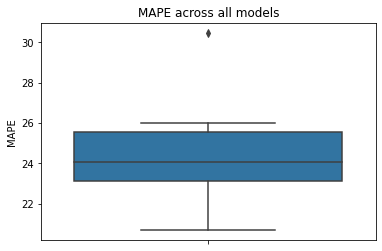

In [21]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig = sns.boxplot(y='MAPE', data=df)
fig.set_title('MAPE across all models')

Next, we can break that down by Brand or Store to see variations in error across our models

Text(0.5, 1.0, 'MAPE by Brand')

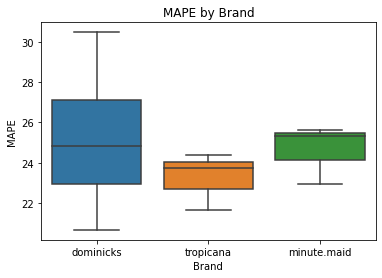

In [22]:
fig = sns.boxplot(x='Brand', y='MAPE', data=df)
fig.set_title('MAPE by Brand')

We can also look at how long models for different brands took to train

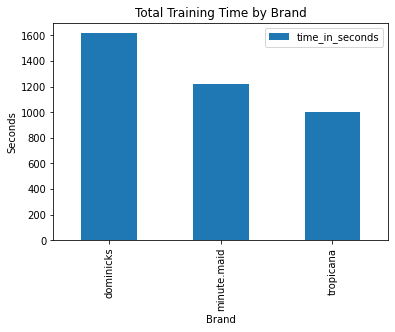

In [23]:
brand = df.groupby('Brand')
brand = brand['Duration'].sum()
brand = pd.DataFrame(brand)
brand['time_in_seconds'] = [time.total_seconds()  for time in brand['Duration']]

brand.drop(columns=['Duration']).plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Seconds')
plt.title('Total Training Time by Brand')
plt.show()

## 7.0 Publish and schedule the pipeline (Optional)


### 7.1 Publish the pipeline
Once you have a pipeline you're happy with, you can publish a pipeline so you can call it programatically later on. See this [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-your-first-pipeline#publish-a-pipeline) for additional information on publishing and calling pipelines.

In [24]:
# published_pipeline = pipeline.publish(name = 'train_many_models',
#                                      description = 'train many models',
#                                      version = '1',
#                                      continue_on_step_failure = False)

### 7.2 Schedule the pipeline
You can also [schedule the pipeline](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-schedule-pipelines) to run on a time-based or change-based schedule. This could be used to automatically retrain models every month or based on another trigger such as data drift.

In [25]:
# from azureml.pipeline.core import Schedule, ScheduleRecurrence
    
# training_pipeline_id = published_pipeline.id

# recurrence = ScheduleRecurrence(frequency="Month", interval=1, start_time="2020-01-01T09:00:00")
# recurring_schedule = Schedule.create(ws, name="training_pipeline_recurring_schedule", 
#                             description="Schedule Training Pipeline to run on the first day of every month",
#                             pipeline_id=training_pipeline_id, 
#                             experiment_name=experiment.name, 
#                             recurrence=recurrence)

## Next Steps

Now that you've trained and scored the models, move on to [03_CustomScript_Forecasting_Pipeline.ipynb](03_CustomScript_Forecasting_Pipeline.ipynb) to make forecasts with your models.